In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import torch

import pandas as pd
import yaml

from matplotlib.lines import Line2D
from os.path import join
from os import listdir

import matplotlib as mpl

from sbibm.visualisation import fig_posterior
from deneb.utils import save

# Download data from WANDB
And put them in dataframes

In [2]:
from utils import obtain_wandb_data

In [3]:
runs_list, runs_list_GAN, runs_list_SRs = obtain_wandb_data(["SLCP", "TwoMoons"])

In [14]:
len(runs_list)

2

In [4]:
runs_df_slcp, runs_df_two_moons = runs_list
runs_df_slcp_GAN, runs_df_two_moons_GAN = runs_list_GAN
runs_df_slcp_SRs, runs_df_two_moons_SRs = runs_list_SRs

There are some entries in runs_list which have nan in the metrics (they were older trials for the same configuration); discard them:

In [35]:
metrics = ["c2st_mean", "c2st_std", 'rmse_val_std', 'rmse_val_mean', 'cal_err_val_std', 'cal_err_val_mean', 
           'r2_val_std', 'r2_val_mean', '_runtime', 'global_step']

In [56]:
runs_df_slcp = runs_df_slcp.dropna(subset=metrics)
runs_df_two_moons = runs_df_two_moons.dropna(subset=metrics)
runs_df_slcp_GAN = runs_df_slcp_GAN.dropna(subset=metrics)
runs_df_two_moons_GAN = runs_df_two_moons_GAN.dropna(subset=metrics)
runs_df_slcp_SRs = runs_df_slcp_SRs.dropna(subset=metrics)
runs_df_two_moons_SRs = runs_df_two_moons_SRs.dropna(subset=metrics)

runs_list = [runs_df_slcp, runs_df_two_moons]
runs_list_SRs = [runs_df_slcp_SRs, runs_df_two_moons_SRs]

In [5]:
runs_df_slcp[runs_df_slcp["name"] == "slcp_energy_score_100000_5"]["epochs"].item()

20000.0

In [6]:
runs_df_slcp.columns

Index(['name', 'ID', 'epochs', 'gen_seed', 'net_type', 'sample_seed',
       'stop_thresh', 'gen_opt_args', 'scoring_rule', 'hold_out_perc',
       'batch_size_perc', 'gen_network_kwargs', 'num_training_simulations',
       'num_simulations_generator', '_step', '_wandb', '_runtime', 'gen_grad',
       'gen_loss', '_timestamp', 'global_step', 'loss', 'dis_iter', 'dis_seed',
       'gen_iter', 'hold_out', 'dis_units', 'dis_nonlin', 'dis_opt_args',
       'max_norm_dis', 'max_norm_gen', 'num_simulations', 'dis_nonlin_kwargs',
       'sbc_hist', 'rmse_val_std', 'c2st_std', 'kernel_bandwidth',
       'early_stop_at_epoch', 'c2st', 'cal_err_val_std', 'rmse_val_mean',
       'c2st_mean', 'r2_val_std', 'train_time', 'r2_val_mean',
       'cal_err_val_mean', 'dreal_mean', 'dfake_mean', 'dis_grad', 'dis_loss',
       'dreal_std', 'dfake_std'],
      dtype='object')

# Calibration metrics with respect to n_gen and n_sim

The following extracts the metrics from the dataframe and puts them in a dictionary of dictionaries.

In [46]:
def extract_dict_from_df(metrics, tasks, runs_list, labels, algos, algos_labels, colors, n_simulations, n_generator, alphas, lss):

    metrics_dict = {task:{} for task in tasks}
    
    for task, task_df  in zip(tasks, runs_list):
        # print(task)
        for algo, algo_label, color in zip(algos, algos_labels, colors):
            # print(algo)
            if algo == "GAN":
                metrics_dict_single = {metric: [] for metric in metrics}
                for n_sim in n_simulations:
                    # print("n_sim", n_sim)
                    entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_"]
                    for metric in metrics: 
                        metrics_dict_single[metric].append(entry[metric].item())
                    metrics_dict_single["algo_label"] = algo_label
                    metrics_dict_single["color"] = color
                    metrics_dict_single["alpha"] = 1
                    metrics_dict_single["ls"] = "solid"

                metrics_dict[f"{task}"][f"{algo}"] = metrics_dict_single

            else:
                for n_gen, alpha, ls in zip(n_generator, alphas, lss):
                    # print("n_gen", n_gen)
                    metrics_dict_single = {metric: [] for metric in metrics}
                    for n_sim in n_simulations:
                        # print("n_sim", n_sim)
                        entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_{n_gen}"]
                        for metric in metrics: 
                            metrics_dict_single[metric].append(entry[metric].item())
                        metrics_dict_single["algo_label"] = algo_label + f" {n_gen}"
                        metrics_dict_single["color"] = color
                        metrics_dict_single["alpha"] = alpha
                        metrics_dict_single["ls"] = ls

                    metrics_dict[f"{task}"][f"{algo}_{n_gen}"] = metrics_dict_single
    return metrics_dict

Do now for the original runs: 

## Plots

### GAN and SR methods only

In [78]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
algos = ["GAN", "energy_score", "kernel_score"]
algos_labels = ["GATSBI", "Energy", "Kernel"]
#algos = ["energy_score", "kernel_score"]
#algos_labels = ["Energy", "Kernel"]
colors = ["tab:red", "tab:green", "tab:olive"]

n_simulations = [1000, 10000, 100000]
n_generator = [3, 5, 10, 20]
alphas = [.1, .4, .7, 1]
lss = ["dotted", "dashed", "dashdot", "solid"]

In [79]:
metrics = ["c2st_mean", "c2st_std", 'rmse_val_std', 'rmse_val_mean', 'cal_err_val_std', 'cal_err_val_mean', 
           'r2_val_std', 'r2_val_mean', '_runtime', 'global_step']

In [80]:
metrics_dict = extract_dict_from_df(metrics=metrics, tasks=tasks, runs_list=runs_list, labels=labels, algos=algos, algos_labels=algos_labels,
colors=colors, n_simulations=n_simulations, n_generator=n_generator, alphas=alphas, lss=lss)

In [81]:
def plot_benchmark_metrics(tasks, labels, metrics_dict, mean_metric, std_metric, ylabel, ylim=None, yticks=None):

    fig, axes = plt.subplots(1, 2, figsize=(1.25*8.27, 3.))
    fig.subplots_adjust(wspace=.275)
    with mpl.rc_context(fname='./matplotlibrc'):

        for j, (task, ax, ttl) in enumerate(zip(tasks, axes, labels)):

            for run in metrics_dict[task]:
                dict_single = metrics_dict[task][run]
                                    
                ax.errorbar(range(3),
                            dict_single[mean_metric],
                            yerr=dict_single[std_metric],
                            color=dict_single["color"],
                            #alpha=dict_single["alpha"],
                            label=dict_single["algo_label"],
                            ls = dict_single["ls"],
                            lw=2.0)

            #if j==0:
            #    ax.legend(frameon=False)

    #        if j==1:
    #            custom_lines = [Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dashed"),
    #                             Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dotted")
    #                            ]
    #            ax.legend(custom_lines, ['GATSBI: opt. hyperparams',
    #                                      'Seq. GATSBI EBM'
    #                                    ], 
    #                      loc="lower left")

            ax.set_xlim([-0.05, 2.05])
            ax.set_xticks([0, 1, 2])
            if yticks is not None:
                ax.set_yticks(yticks)

            #ax.set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
            ax.set_xticklabels([r"1000", "10 000", "100 000"])
            ax.set_ylim(ylim)
            ax.set_xlabel("Number of simulations")
            ax.set_ylabel(ylabel)
            ax.set_title(ttl)

        fig.text(0.05, .89, "A", fontsize=18)
        fig.text(0.48, .89, "B", fontsize=18)

        plt.subplots_adjust(hspace=2.)

        #plt.savefig("plots/Figure2.pdf")
        
        plt.legend(bbox_to_anchor=(1.06,0.5), loc="center left", frameon=True)
    
    return fig, ax

C2ST: the smaller the better

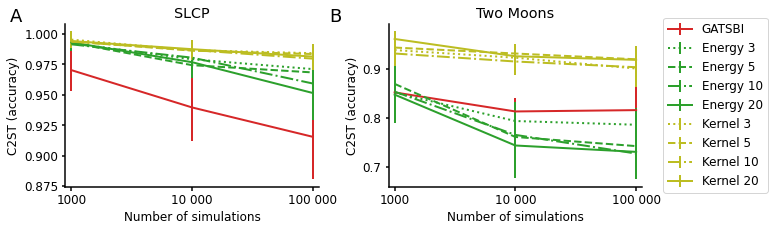

In [82]:
fig, ax = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", None, None)
fig.savefig("plots/C2ST_figure.pdf")
#fig, ax = plot_benchmark_metrics(tasks, labels, metrics_dict, "c2st_mean", "c2st_std", "C2ST (accuracy)", (0.5,1), [0.5, .75, 1.])

R2: the larger the better

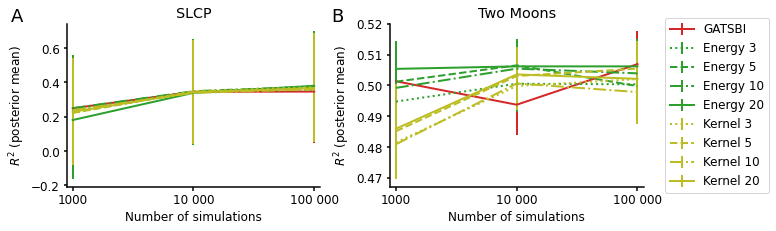

In [83]:
fig, ax = plot_benchmark_metrics(tasks, labels, metrics_dict, "r2_val_mean", "r2_val_std", r"$R^2$ (posterior mean)", None)
fig.savefig("plots/benchmarks_r2_figure.pdf")

RMSE: the smaller the better

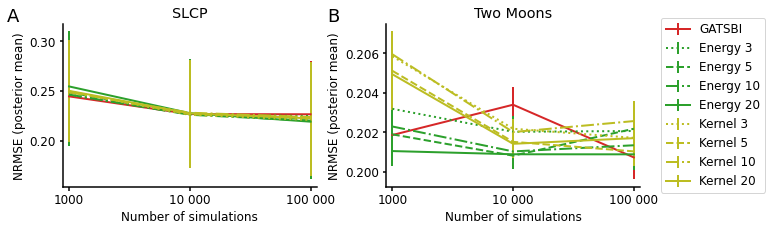

In [84]:
fig, ax = plot_benchmark_metrics(tasks, labels, metrics_dict, "rmse_val_mean", "rmse_val_std", "NRMSE (posterior mean)", None)
fig.savefig("plots/benchmarks_rmse_figure.pdf")

Cal error: the smaller the better

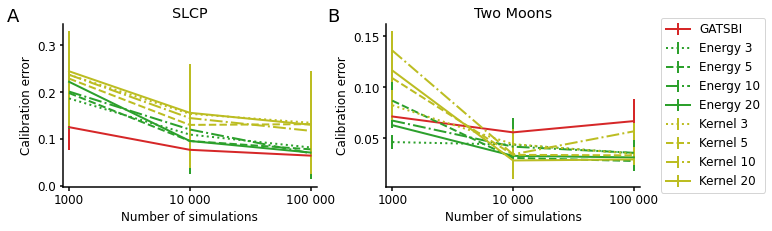

In [85]:
fig, ax = plot_benchmark_metrics(tasks, labels, metrics_dict, "cal_err_val_mean", "cal_err_val_std", "Calibration error", None)
fig.savefig("plots/benchmarks_cal_err_figure.pdf")

## All methods (this only includes the $m=20$ runs)

In [61]:
runs_df_slcp_SRs_20 = runs_df_slcp_SRs[runs_df_slcp_SRs["num_simulations_generator"] == 20]
runs_df_two_moons_SRs_20 = runs_df_two_moons_SRs[runs_df_two_moons_SRs["num_simulations_generator"] == 20]
runs_list_SRs_20 = [runs_df_slcp_SRs_20, runs_df_two_moons_SRs_20]

In [65]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
algos = ["energy_score", "kernel_score"]
algos_labels = ["Energy Score", "Kernel Score"]
colors = ["tab:green", "tab:olive"]

n_simulations = [1000, 10000, 100000]
n_generator = [20]
alphas = [1]
lss = ["solid"]

In [66]:
metrics_dict_SRs_20 = extract_dict_from_df(metrics=metrics, tasks=tasks, runs_list=runs_list_SRs_20, labels=labels, algos=algos, algos_labels=algos_labels,
colors=colors, n_simulations=n_simulations, n_generator=n_generator, alphas=alphas, lss=lss)

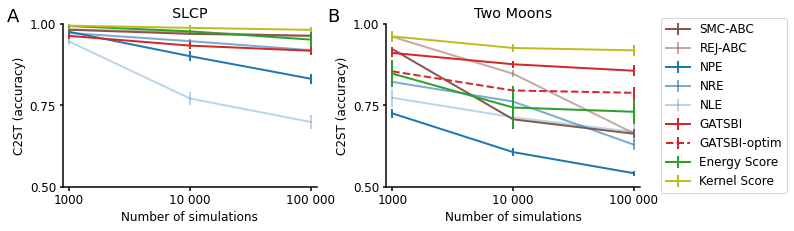

In [69]:
tasks = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
algos = ["GATSBI", "NLE", "NRE", "NPE","REJ-ABC", "SMC-ABC"]
colors = [*["tab:brown"]*2, *["tab:blue"]*3,"tab:red"]
alphas = [1., .5, 1., .6, .3, 1.]


model_perf = {}
for task in tasks:
    with open(join("plotting_data/", 
                   "%s_c2st_scores.yaml"  % task), 
              "r") as f:
        model_perf[task] = yaml.load(f, Loader=yaml.FullLoader)


fig, axes = plt.subplots(1, 2, figsize=(1.25*8.27, 3.))
fig.subplots_adjust(wspace=.275)
with mpl.rc_context(fname='./matplotlibrc'):

    for j, (task, ax, ttl) in enumerate(zip(tasks, axes, labels)):
        mdl = model_perf[task]["c2st_mean"]
        sem = model_perf[task]["c2st_sem"]
        
        # first do the original methods
        for i, (alg, color, alpha) in enumerate(zip(algos[::-1],
                                                    colors,
                                                    alphas)):
            ax.errorbar(range(3),
                        mdl[alg],
                        yerr=sem[alg],
                        color=color,
                        alpha=alpha,
                        label=alg,
                        lw=2.0)
            
        if task == "two_moons":
            alg = "GATSBI-optim"
            ax.errorbar(range(3),
                        mdl[alg],
                        yerr=sem[alg],
                        color="tab:red",
                        linestyle="dashed",
                        alpha=1.,
                        label="GATSBI-optim",
                        lw=2.0)
#             alg = "GATSBI-EBM"
#             ax.errorbar(range(3),
#                         mdl[alg],
#                         yerr=sem[alg],
#                         color="tab:red",
#                         linestyle="dotted",
#                         alpha=1.,
#                         label="GATSB_EBM",
#                         lw=2.0)

        # then do the SR methods
        for run in metrics_dict_SRs_20[task]:
                dict_single = metrics_dict_SRs_20[task][run]
                                    
                ax.errorbar(range(3),
                            dict_single["c2st_mean"],
                            yerr=dict_single["c2st_std"],
                            color=dict_single["color"],
                            #alpha=dict_single["alpha"],
                            label=dict_single["algo_label"][:-3],
                            ls = dict_single["ls"],
                            lw=2.0)

        # if j==0:
        #     ax.legend(frameon=False)

        if j==1:
            custom_lines = [Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dashed"),
#                             Line2D([0], [0], color="tab:red", lw=2.0, linestyle="dotted")
                            ]
            ax.legend(custom_lines, ['GATSBI: opt. hyperparams',
#                                      'Seq. GATSBI EBM'
                                    ], 
                      loc="lower left")
            
            
        ax.set_xlim([-0.05, 2.05])
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0.5, .75, 1.])
        
        #ax.set_xticklabels([r"$10^3$", r"$10^4$", r"$10^5$"])
        ax.set_xticklabels([r"1000", "10 000", "100 000"])
        ax.set_ylim((0.5, 1.))
        ax.set_xlabel("Number of simulations")
        ax.set_ylabel("C2ST (accuracy)")
        ax.set_title(ttl)

    fig.text(0.05, .89, "A", fontsize=18)
    fig.text(0.48, .89, "B", fontsize=18)

    plt.subplots_adjust(hspace=2.)
    
    plt.legend(bbox_to_anchor=(1.06,0.5), loc="center left", frameon=True)

    plt.savefig("plots/C2ST_figure_all_methods.pdf")

## Tables

In [16]:
#! pip install tabulate
from tabulate import tabulate
from copy import deepcopy

In [17]:
def print_table(metrics_dict, task, field="c2st", latex=False, file=None, tranpose=False):

    has_std = False
    
    if field in ["rmse", "cal_err", "r2", "c2st"]:
        has_std = True
        if field != "c2st":
            field += "_val"

    name_list = ["",]
    
    n_sim_list = [1000,10000,100000]
    all_lists = []
    
    for run in metrics_dict[task]:
        name_list.append(metrics_dict[task][run]["algo_label"])            
            
    all_lists.append(name_list)
    
    for i, n_sim in enumerate(n_sim_list):
        inner_list = [n_sim]    
        for run in metrics_dict[task]:
            dict_single = metrics_dict[task][run]
            if has_std:
                inner_list.append(f"{dict_single[f'{field}_mean'][i]:.2f} $\pm$ {dict_single[f'{field}_std'][i]:.2f}" )
                # inner_list.append(f"{dict_single[f'{field}_mean'][i]:.2f} "+ u"\u00B1"+ f"  {dict_single[f'{field}_std'][i]:.2f}" )
            else:
                inner_list.append(f"{dict_single[f'{field}'][i]:.2f}" )
                
        all_lists.append(deepcopy(inner_list))
    
    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))

    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"
    else: 
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"        

Write all tables and store them.

In [18]:
for task  in tasks:
    for metric in ["c2st", "rmse", "global_step", "_runtime", "cal_err", "r2"]: 
        print_table(metrics_dict, task=task, field=metric, file=f"tables/{task}_{metric}", latex=True)

## Fix now n_gen=20 and create a single table for all entries

Each column should be GAN/En/Kernel for 1000/10k/100k training simulations. Rows are then the different metrics

Easier to start from the original data frame and extract lists accordingly:

In [19]:
n_gen = 20 

metrics = ["c2st_mean", "c2st_std", 'rmse_val_std', 'rmse_val_mean', 'cal_err_val_std', 'cal_err_val_mean', 
           'r2_val_std', 'r2_val_mean', '_runtime', 'global_step']
metrics_dict_fixed_n_gen = {task: {} for task in tasks}

for task, task_df  in zip(tasks, runs_list):
    for algo, algo_label, color in zip(algos, algos_labels, colors):
        for n_sim in n_simulations:
            metrics_dict_single = {}
            if algo == "GAN":
                entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_"]
            else:
                # consider only the correct number of generations
                entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_{n_gen}"]

            for metric in metrics: 
                metrics_dict_single[metric] = entry[metric].item()
            # add the label to metrics_dict_single
            metrics_dict_single["algo_label"] = algo_label + f" {n_sim}"

            # store in the overall dictionary
            metrics_dict_fixed_n_gen[f"{task}"][f"{algo}_{n_sim}"] = metrics_dict_single
            

Now print the table

In [20]:
def print_table_fixed_n_gen(metrics_dict, task, latex=False, file=None, tranpose=False):

    metrics = [["c2st_std", "c2st_mean",], ['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
                   ['r2_val_std', 'r2_val_mean'], ['_runtime'], ['global_step']]
    metric_names = [r"C2ST $ \downarrow $", r"NRMSE $ \downarrow $", r"Cal. Err. $ \downarrow $", r"R$^2$ $ \uparrow $", "Runtime (sec)", "Early stopping epoch"]
    
    name_list = ["",]
    
    all_lists = []
    for run in metrics_dict[task]:
        name_list.append(metrics_dict[task][run]["algo_label"])            
            
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    
        for run in metrics_dict[task]:
            dict_single = metrics_dict[task][run]

            if len(metric) == 2:
                inner_list.append(f"{dict_single[metric[1]]:.2f} $\pm$ {dict_single[metric[0]]:.2f}" )
            else:
                inner_list.append(f"{dict_single[metric[0]]}" )
                
        all_lists.append(deepcopy(inner_list))
    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"
    else: 
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow")) #  tablefmt="latex_booktabs"

In [21]:
for task in tasks:
    print_table_fixed_n_gen(metrics_dict_fixed_n_gen, task, latex=True, file=f"tables/{task}_all_metrics_n_gen={n_gen}")

Actually do the same fixing both n_sim and n_gen

In [22]:
n_gen = 20 
n_sim = 100000

metrics = ["c2st_mean", "c2st_std", 'rmse_val_std', 'rmse_val_mean', 'cal_err_val_std', 'cal_err_val_mean', 
           'r2_val_std', 'r2_val_mean', '_runtime', 'global_step']
metrics_dict_fixed_n_gen_n_sim = {task: {} for task in tasks}

for task, task_df  in zip(tasks, runs_list):
    for algo, algo_label, color in zip(algos, algos_labels, colors):
        metrics_dict_single = {}
        if algo == "GAN":
            entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_"]
        else:
            # consider only the correct number of generations
            entry = task_df[task_df["name"] == f"{task}_{algo}_{n_sim}_{n_gen}"]

        for metric in metrics: 
            metrics_dict_single[metric] = entry[metric].item()
        # add the label to metrics_dict_single
        metrics_dict_single["algo_label"] = algo_label 
        
        # store in the overall dictionary
        metrics_dict_fixed_n_gen_n_sim[f"{task}"][f"{algo}_{n_sim}"] = metrics_dict_single
            

In [23]:
for task in tasks:
    print_table_fixed_n_gen(metrics_dict_fixed_n_gen_n_sim, task, latex=True, tranpose=True,
                            file=f"tables/{task}_all_metrics_n_gen={n_gen}_n_sim={n_sim}")

Now print the table

# Load samples obtained by my method

Need to identify the run id from the run dataframe and then load results in the folder:


`two_moons/wandb/run-20220413_115328-32fdk207/files/gatsbi_results`

We have overall 24 trainings (for each task): 

- number of simulations (3)
- SR (2)
- n_gen (4)

In [25]:
from glob import glob

In [26]:
!mkdir plots/two_moons plots/slcp

mkdir: cannot create directory 'plots/two_moons': File exists
mkdir: cannot create directory 'plots/slcp': File exists


In [27]:
obs_number = 4

In [28]:
root_folder = "/data/localhost/pacchiar/GATSBI_extension_res/"

In [29]:
task_name_list = ["slcp", "two_moons"]
labels = ["SLCP", "Two Moons"]
df_list = [runs_df_slcp_SRs, runs_df_two_moons_SRs]

scoring_rule_list = ["energy_score", "kernel_score"]
n_gen_list = [3, 5, 10, 20]
n_sim_list = [1000, 10000, 100000]
scoring_rule_list = ["energy_score"]
n_gen_list = [20]
n_sim_list = [100000]


for df_in, task_name, label in zip(df_list, task_name_list, labels):
    for scoring_rule in scoring_rule_list:
        for n_gen in n_gen_list:
            for n_sim in n_sim_list:

                # obtain the identifier
                df = df_in[df_in.scoring_rule == scoring_rule]
                df = df[df.num_simulations_generator == n_gen]
                df = df[df.num_training_simulations == n_sim]
                identifier = df["ID"].item()

                # obtain the path
                correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")
                if len(correct_folder) == 0:
                    print("No match")
                    continue
                correct_folder = correct_folder[0]
    
                # load posterior samples
                samples = np.load(correct_folder + "/files/gatsbi_results/" + f"gatsbi_samples_obs_num_{obs_number}.npy")

                # plot the samples
                chart = fig_posterior(
                    task_name=task_name,
                    num_observation=obs_number,
                    samples_tensor=torch.tensor(samples),
                    samples_name=label,
                    samples_color="#EC051C")

                chart.save(f"./plots/{task_name}/posterior_samples_{scoring_rule}_{n_gen}_{n_sim}.png", webdriver='firefox', scale_factor=2)  # I am using a firefox backend                

The following would do similar as before but for GAN. We do not run it now as we do not report it.

    df_list = [runs_df_slcp_GAN, runs_df_two_moons_GAN]

    for df_in, task_name, label in zip(df_list, task_name_list, labels):
        for n_sim in n_sim_list:

            # obtain the identifier
            df = df_in[df_in.num_training_simulations == n_sim]
            identifier = df["ID"].item()

            # obtain the path
            correct_folder = glob(root_folder + task_name + f"/wandb/*{identifier}*")

            if len(correct_folder) == 0:
                print("No match")
                continue
            correct_folder = correct_folder[0]

            # load posterior samples
            samples = np.load(correct_folder + "/files/gatsbi_results/" + f"gatsbi_samples_obs_num_{obs_number}.npy")

            # plot the samples
            chart = fig_posterior(
                task_name=task_name,
                num_observation=obs_number,
                samples_tensor=torch.tensor(samples),
                samples_name=label,
                samples_color="#EC051C")

            chart.save(f"./plots/{task_name}/posterior_samples_GAN_{n_sim}.png", webdriver='firefox', scale_factor=2)  # I am using a firefox backend                        